# Final project -- Numerical Analysis -- 2020/2021

## General goal

Consider the hyper-cube $\Omega := [-1,1]^d$ in dimension `d`.

Given a function $f: \Omega \mapsto R$, find $u: \Omega \mapsto R$ such that 

$
- \Delta u  + u = f, \text{ in } \Omega
$

$
\frac{\partial u}{\partial n} = 0 \text{ on } \partial \Omega
$

using Chebyshev spectral elements, and in a matrix-free framework.

## Due date: 

- MHPC students: 20 February 2021
- DSSC/LM/PHD students: 1 day before the oral examination

## General definitions

We recall here some general definitions that will be useful throughout the project.

- The space $Q^p(\Omega)$ is the space of polynomials of order $p$ in each coordinate direction. The dimension of $Q^p$ is $(p+1)^d$ where $d$ is the dimension of the space. 

- A tensor product basis for $Q^p(\Omega)$ can be constructed from a basis for $P^p([-1,1])$, by arranging the indices in d-dimensional arrays, i.e., if $\{v_i\}_{i=0}^p$ is a basis for $P^p([-1,1])$, then, for example, 
$
v_{ijk} := v_i(x_0)v_j(x_1)v_k(x_2)
$
is a basis for $Q^p([-1,1]^3)$.

- Chebyshev points of type 2 are Chebishev points in one dimension that include end points. These are not minimizers of the linfty norm of the Lebesgue function (those are Chebishev points of type 1), but are minimizers of Lebesgue function when you constrain two of the points to coincide with the extremes of the interval $[-1,1]$. You can obtain those points by calling `numpy.polynomial.chebyshev.chebpts2`.

- Chebyshev spectral elements are the tensor product basis for $Q^p(\Omega)$, generated by the Lagrange basis functions constructed using as support points the Chebyshev points of type 2. In one dimension, for degree=5, npoints=6, they look like

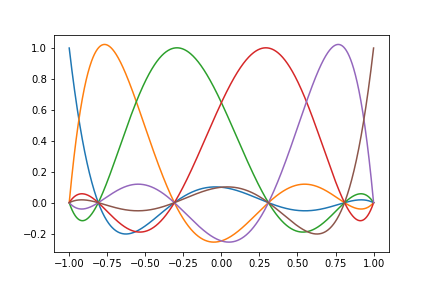

- Integration in each coordinate direction can be performed using Gauss quadrature formulas, which can be queried by the function `numpy.polynomial.legendre.leggauss`. That function returns a tuple of two objects,  containing both the quadrature points `q` and the quadrature weights `w`, i.e., `q, w = numpy.polynomial.legendre.leggauss(nq)`.

- The construction of a Lagrange basis can be done easily by calling `scipy.interpolate.lagrange(X, ei)` where `X` are the interpolation points, and `ei` is a vector containing all zeros, except a one in the position corresponding to the index i. For example, the following code 

~~~
X = numpy.polynomial.chebyshev.chebpts2(6)
e_3 = zeros((6,))
e_3[3] = 1

B_3 = lagrange(X, e_3)
B_3_prime = polyder(B_3)

x = linspace(-1,1,501)
plot(x, B_3(x))
plot(X, 0*X, 'ro')
figure()
plot(x, B_3_prime(x))
plot(X, 0*X, 'ro')
~~~

will produce the following pictures

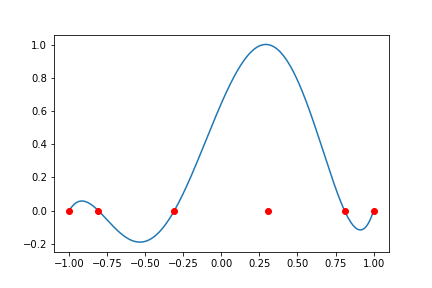

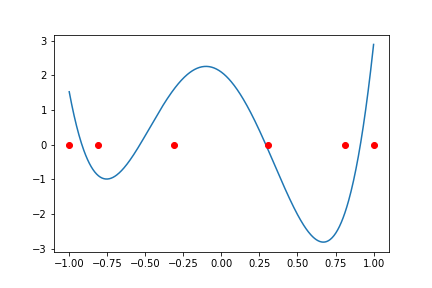

Which correspond to the fourth (`index=3`) Chebishev spectral basis function and its derivative, for the space $P^5([-1,1])$.

The functions `B_3` and `B_3_prime` computed above are callable functions, i.e., you can evaluate the basis and its derivative as normal functions, and they accept as input numpy arrays.

## Weak formulation

The weak form of the problem reads:

Given $f:\Omega \mapsto R$, find $u\in H^1(\Omega)$ such that

$
\int_\Omega \nabla u \cdot \nabla v + \int_\Omega u v = \int_\Omega f v \qquad \forall v \in H^1(\Omega)
$

## Discrete weak formulation (one dimensional case)

Given a finite dimensional space $V_h \subset H^1([-1,1])$ such that  $V_h = \text{span}\{v_i\}_{i=0}^p$, then
the discrete problem reads:

Find $u$ such that

$
A u = f 
$

where $A$ is a matrix in  $R^{(p+1)\times(p+1)}$  and $f$ is a vector in $R^{(p+1)}$ 

$
A_{ij} = \int_\Omega \nabla v_j \cdot \nabla v_i+\int_\Omega  v_j  v_i, \qquad f_i = \int_\Omega f v_i
$

that is (using a quadrature with $q_\alpha$ and $w_\alpha$ as points and weights):

$
A_{ij} = \sum_{\alpha=0}^{nq-1}\left( v'_j(q_\alpha) v'_i(q_\alpha)+  v_j(q_\alpha)  v_i(q_\alpha)\right)w_\alpha
$

$
f_{i} = \sum_{\alpha=0}^{nq-1} v_j(q_\alpha) f(q_\alpha) w_\alpha
$

Let's assume we have computed the matrices $B_{i\alpha} := v_i(q_\alpha)$, and $D_{i\alpha} := v'_i(q_\alpha)$ containing the evaluation of all basis functions and of their derivatives in the quadrature points $q_\alpha$.  

The matrix $A$ can then be written as

$
A_{ij} = \sum_\alpha \left(D_{i\alpha} D_{j\alpha} w_\alpha + B_{i\alpha} B_{j\alpha} w_\alpha\right) = K_{ij} + M_{ij}
$

where $K$ is usually known as the one dimensional stiffness matrix, and $M$ as the one dimensional mass matrix:


$
K_{ij} = \sum_\alpha \left(D_{i\alpha} D_{j\alpha} w_\alpha \right)
$


$
M_{ij} = \sum_\alpha \left(B_{i\alpha} B_{j\alpha} w_\alpha \right)
$

Using numpy and Lapack, these can be computed efficiently by calling `einsum`:

~~~
K = einsum('iq, q, jq', D, w, D)
M = einsum('iq, q, jq', B, w, B)
~~~

where the function `einsum` interprets the first argument (a string) as a list of indices over which sum should occur. The list must be of the same length of the other arguments (3 in this case), and the number of indices for each entry musth match the input (i.e., `iq` for `D`, and `q` for `w`). The three arrays are multiplied entry by entry, and if an index is repeated in the description, those entries are summed over (see the documentation).

## Higher dimensional case

If we have already computed the one dimensional matrices $B_{i\alpha} = v_i(q_\alpha)$ and $D_{i\alpha} := v'_i(q_\alpha)$ we can compute easily the 2 and 3 dimensional versions of the stiffness, mass, and system matrices.

In particular, defining $q_{\alpha\beta} := (q_\alpha, q_\beta)$, and $w_{\alpha\beta} = w_\alpha w_\beta$, we have

$\nabla v_{ij}(q_{\alpha\beta}) \cdot \nabla v_{kl}(q_{\alpha\beta}) := v'_i(q_{\alpha})v_j(q_{\beta})v'_k(q_{\alpha})v_l(q_{\beta}) + v_i(q_{\alpha})v'_j(q_{\beta})v_k(q_{\alpha})v'_l(q_{\beta})$. 

Integrating with quadrature twice (once for each dimension), we get:

$
K_{ij,kl} := \sum_q \sum_p v'_i(X_q)v_j(X_p)v'_k(X_q)v_l(X_p) + v_i(X_q)v'_j(X_p)v_k(X_q)v'_l(X_p) w_p w_q
$

These are easily expressed directly through python `einsum`, i.e., 

```
KM = einsum('iq, jp, q, p, kq, lp -> ijkl', D, B, w, w, D, B)
MK = einsum('iq, jp, q, p, kq, lp -> ijkl', D, B, w, w, B, D)
KK = KM+MK
```

Or, if we have already the one dimensional matrices $K_{ij}$ and $M_{ij}$, then the above become:

$
A_{ij,kl} := K_{ik}M_{jl} + M_{ik}K_{jl} + M_{ik}M_{jl}
$

which, using the `einsum` command, becomes:

```
KM = einsum('ik, jl -> ijkl', K, M)
MK = einsum('ik, jl -> ijkl', M, K)
MM = einsum('ik, jl -> ijkl', M, M)
KK = KM+MK
AA = KK+MM

```

The resulting array can be reshaped to a two dimensional matrix by calling `AA.reshape((n**2, n**2))`, and solved for using `linalg.solve`.

Similarly in 3 dimensions:


$
A_{ijk,lmn} := (K_{il}M_{jm}M_{kn}+M_{il}K_{jm}M_{kn}+M_{il}M_{jm}K_{kn})+M_{il}M_{jm}M_{kn}
$

Sums of the kind $D_{ijk,lmn} = A_{il}B_{jm}C_{kn}$ can be expressed using `einsum` as

```
D = einsum('il, jm, kn -> ijklmn', A, B, C)
```

And the resulting six-dimensional array can be reshaped to a matrix by calling `D.reshape((n**3, n**3))`.

## Intermediate assignments

### 1. One dimensional matrices
Write a function that, given the number of Chebishev points `n`, returns `K`, `M`, and `A` for a one dimensional problem, integrated exactly using Gauss quadrature formulas with the correct number of quadrature points 

In [1]:
import numpy as np
from numpy import polynomial
from scipy import interpolate
import matplotlib.pyplot as plt

In [2]:
def compute_one_dimensional_matrices(n):
    '''
    By using n Chebyshev points, the function
    returns one dimensional stiffnes matrix K,
    mass matrix M, matrix A, i.e the sum of K 
    and M, and matrix B, which stores the values 
    of the basis functions at the quadrature points
    '''
    X = np.polynomial.chebyshev.chebpts2(n)
    
    '''
    Quadrature points and respective wheights.
    With q quadrature points we are able to 
    exactly integrate polynomials of order up
    to (2q - 1). Since in the problem we are 
    going to multiply two basis function of
    order n - 1 we obtain a polynomial of order
    2n - 2, hence, using q = n quadrature points
    will be enough
    '''
    q, w = np.polynomial.legendre.leggauss(n)    
    
    '''
    I build the standard basis that will be
    needed for building the lagrange basis.
    Then, I construct the lagrange basis
    and also its derivative
    '''
    e_basis = [np.zeros(n) for i in range(n)]
    for i in range(n):
        e_basis[i][i] = 1
        
    lagrange_basis = [interpolate.lagrange(X, e_basis[i]) for i in range(n)]
    lagrange_basis_der = [np.polyder(lagrange_basis[i]) for i in range(n)]
    
    '''
    I initialize B and D and I fill them
    by evaluating the basis functions and
    their derivatives on the quadrature points
    '''
    B = np.empty((n,n), dtype=np.float64)
    D = np.empty((n,n), dtype=np.float64)
    
    for i in range(n):
        B[i] = lagrange_basis[i](q)
        D[i] = lagrange_basis_der[i](q)
                
    '''
    I construct the stiffnes matrix K and
    the mass matrix M using Einstein sum
    and then the final matrix A
    '''
    K = np.einsum('iq, q, jq', D, w, D)
    M = np.einsum('iq, q, jq', B, w, B)
    
    A = K + M
    
    return K, M, A, B

### 2. Error in one dimension

Using 

$
u_{exact}(x) = \cos(\pi x)
$

as the exact solution, compute the forcing term $f$ that should go on the right hand side of the system to ensure that the exact solution is $u$, i.e., $f = -\Delta u + u$  

Use $f$ to compute the right hand side of your problem, and solve the problem (using `linalg.solve`) for increasing numbers of Chebishev points. Compute the $L^2$ error between the exact solution and the computed approximatio, using a higher order quadrature w.r.t. what you used to assemble the matrices. 

Plot the error as a function of $n$, for $n$ in $[10,...,20]$.

In [3]:
def exact_one_d(x):
    '''
    returns the exact solution in 1D
    '''
    return np.cos(np.pi*x)
    
def rhs_one_d(x):
    '''
    returns the forcing term in 1D
    '''
    return (1 + np.pi**2) * np.cos(np.pi*x)

def lagrange_basis(n):
    '''
    returns the lagrange basis of order n
    '''
    X = np.polynomial.chebyshev.chebpts2(n)
    
    e_basis = [np.zeros(n) for i in range(n)]
    for i in range(n):
        e_basis[i][i] = 1
    
    lagrange_b = [interpolate.lagrange(X, e_basis[i]) for i in range(n)]
    return lagrange_b

def compute_approx_u(n, rhs, x):
    '''
    returns an approximation of the solution
    given the number of Chebyshev points,
    the forcing term and the points on which
    you want to evaluate the approximation
    '''
    _, _, A, B = compute_one_dimensional_matrices(n)
    q, w = np.polynomial.legendre.leggauss(n)
    X = np.polynomial.chebyshev.chebpts2(n)
    
    '''
    I evaluate the forcing term on the
    quadrature points, I then evaluate 
    the integral by using the matrix B
    and the quadrature weights and I then
    solve the linear system for u
    '''
    f_eval = rhs(q)
    f = np.einsum('ia, a, a', B, w, f_eval)
    u = np.linalg.solve(A, f)
    
    
    '''
    Using u and the lagrange basis I evaluate
    an approximation of the solution using
    the points given as input of the function
    '''
    lagrange_b = lagrange_basis(n)
    u_approx = np.zeros((np.size(x)))
    for i in range(0, n):
        u_approx = u_approx + u[i]*lagrange_b[i](x)
            
    return u_approx

[5.245885796863492e-05,
 9.949863765521727e-07,
 1.0086584305041332e-06,
 1.3829472555008671e-08,
 1.3961267131252441e-08,
 1.4480600396257781e-10,
 1.458262893918668e-10,
 4.174333024960487e-12,
 1.0784260165055444e-11,
 1.6847322238083444e-11]

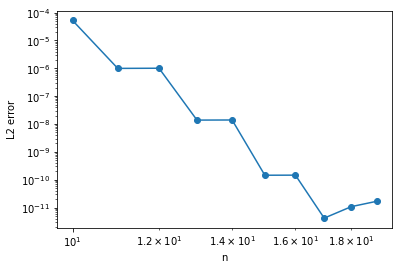

In [4]:
def compute_error_one_d(n, exact, rhs):
    '''
    Returns the L2 error between the exact
    solution and the approximated one 
    given the form of the exact solution
    and of the forcing term
    '''
    q_points, q_weigths = np.polynomial.legendre.leggauss(n*2)
    
    '''
    evaluation of the exact solution
    and of the approximated one
    '''
    u_approx = compute_approx_u(n,rhs,q_points)
    u_exact = exact(q_points)
    
    '''
    computation of the L2 error
    '''
    error = u_exact - u_approx
    error_square = error * error
    l2_error_square = np.sum(error_square * q_weigths)
    l2_error = np.sqrt(l2_error_square)
    
    return l2_error

error = []
all_n = range(10,20)
for n in all_n:
    error.append(compute_error_one_d(n, exact_one_d, rhs_one_d))

plt.loglog(all_n, error, 'o-')
plt.xlabel("n")
plt.ylabel("L2 error")
error

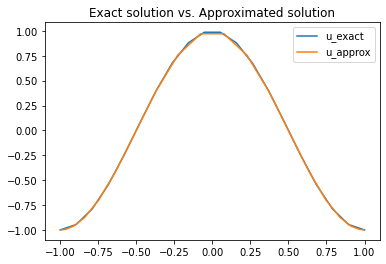

In [5]:
'''
Graphical representation of the exact
solution and of the approximate one 
using 20 points
'''
n = 10
X = np.linspace(-1,1,20)
q, w = np.polynomial.legendre.leggauss(n*2)

plt.plot(X, exact_one_d(X), label = "u_exact")
plt.plot(q, compute_approx_u(n, rhs_one_d, q), label = "u_approx")
plt.legend()
plt.title("Exact solution vs. Approximated solution")
plt.show()


### 3. Two dimensional matrices

Write a function that, given the number of Chebishev points `n` per each coordinate direction, returns `K`, `M`, and `A` for a two dimensional problem, integrated exactly using Gauss quadrature formulas with the correct number of quadrature points (as matrices, i.e., reshaped to be two dimensional)

In [6]:
def compute_two_dimensional_matrices(n):
    '''
    returns the matrices K, M, A and B
    for the two-dimensional case by using
    the ones of the one-dimensional case
    '''
    K, M, A, B = compute_one_dimensional_matrices(n)
    
    BB = np.einsum('ik, jl -> ijkl', B, B)
    KM = np.einsum('ik, jl -> ijkl', K, M)
    MK = np.einsum('ik, jl -> ijkl', M, K)
    MM = np.einsum('ik, jl -> ijkl', M, M)
    KK = KM+MK
    AA = KK+MM
    
    AA = AA.reshape((n**2,n**2))
    KK = KK.reshape((n**2,n**2))
    MM = MM.reshape((n**2,n**2))
    BB = BB.reshape((n**2,n**2))
    
    return KK, MM, AA, BB

### 3. Error in two dimension

Using 

$
u_{exact}(x) = \cos(\pi x_0)\cos(\pi x_1)
$

as the exact solution, compute the forcing term $f$ that should go on the right hand side of the system to ensure that the exact solution is $u$, i.e., $f = -\Delta u + u$  

Use $f$ to compute the right hand side of your problem, and solve the problem (using `linalg.solve`) for increasing numbers of Chebishev points. Compute the $L^2$ error between the exact solution and the computed approximatio, using a higher order quadrature w.r.t. what you used to assemble the matrices. 

A solution should look like:

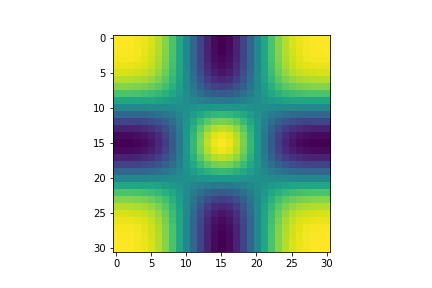

The plot was obtained as `imshow(u.reshape((n,n))`.

Plot the error as a function of $n$, for $n$ in $[10,...,20]$.

In [7]:
def exact_two_d(x,y):
    '''
    returns the exact solution in 2D
    '''
    return np.cos(np.pi*x)*np.cos(np.pi*y)

def rhs_two_d(x,y):
    '''
    returns the forcing term in 1D
    '''
    c = exact_two_d(x,y)
    return (1 + 2*np.pi**2)*c

def compute_approx_u_two_d(n, rhs, x, y):
    '''
    returns an approximation of the solution
    for the two-dimensional case
    '''
    _, _, AA, BB = compute_two_dimensional_matrices(n)
    
    q, w = np.polynomial.legendre.leggauss(n)
    X = np.polynomial.chebyshev.chebpts2(n) 
    XX, YY = np.meshgrid(q, q)
    
    '''
    evaluation the function on the points,
    computation of the rhs using the quadrature
    weights and the two-dimensional matrix B,
    and solution of the linear system
    '''
    F_eval = rhs(XX, YY).reshape((n**2))
    W = np.einsum('i, j', w, w).reshape((n**2))
    RHS = np.einsum('ia, a, a', BB, F_eval, W)
    
    u = np.linalg.solve(AA, RHS).reshape((n,n))
    
    '''
    using u, the lagrange basis and the 
    points given as input an approximation
    is computed
    '''
    lagrange_b = lagrange_basis(n)
    u_approx = np.zeros(
        (np.size(x), np.size(y)), 
        dtype=np.float64
    )
    
    for i in range(n):
        for j in range(n):
            u_approx = u_approx + u[i,j]*lagrange_b[i](x)*lagrange_b[j](y)
            
    return u_approx

[7.284556513952431e-05,
 1.3763263461503485e-06,
 1.4092941218661214e-06,
 1.924692120440792e-08,
 1.957599153055376e-08,
 2.0232984040425885e-10,
 2.0492353336893847e-10,
 2.416978853945881e-12,
 5.616875212521257e-12,
 1.1348557696544149e-11]

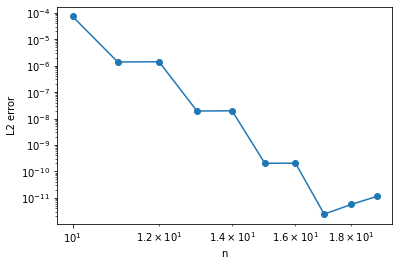

In [8]:
def compute_error_two_d(n, exact, rhs):    
    '''
    Returns the L2 error between the exact
    solution and the approximated one 
    given the form of the exact solution
    and of the forcing term for the
    two-dimensional case
    '''
    q_points, q_weigths = np.polynomial.legendre.leggauss(n*2)
    W = np.einsum('i, j', q_weigths, q_weigths)
    XX, YY = np.meshgrid(q_points,q_points)
    
    qx = q_points.reshape(2*n,1)
    qy = q_points.reshape(1,2*n)
    
    '''
    evaluation of approximated solution
    and of exact solution
    '''
    u_approx = compute_approx_u_two_d(n, rhs, qx, qy)
    u_exact = exact(XX,YY)
    
    '''
    evaluation of the L2 error
    '''
    error = u_exact - u_approx
    error_square = error * error
    l2_error_square = np.sum(error_square * W) 
    l2_error = np.sqrt(l2_error_square)
    
    return l2_error
    

error = []
all_n = range(10,20)
for n in all_n:
    error.append(compute_error_two_d(n, exact_two_d, rhs_two_d))

plt.loglog(all_n, error, 'o-')
plt.xlabel('n')
plt.ylabel('L2 error')
error

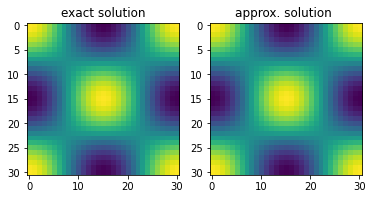

In [9]:
'''
graphical representation
of exact and approximated solution
using equispaced points
'''

n = 31
X = np.linspace(-1,1,n)
q, w = np.polynomial.legendre.leggauss(n)
x_points = X.reshape(n,1)
y_points = X.reshape(1,n)

fig = plt.figure()

fig.add_subplot(121)
plt.title('exact solution')
plt.imshow(exact_two_d(x_points,y_points))

fig.add_subplot(122)
plt.title('approx. solution ')
plt.imshow(compute_approx_u_two_d(n, rhs_two_d, x_points, y_points))

plt.show()

### 4. Conjugate gradient

The conjugate gradient method does not require the knowledge of the matrix, but only of the result of the matrix vector product with the system matrix A. 

Implement a version of the conjugate gradient method that solves the linear system of the two dimensional problem (up to a given tolerance) by only using a function that implements the matrix vector product, i.e., given a `matvec` function, for example defined by  

~~~
def matvec(src):
    return A.dot(src)
~~~

build a conjugate gradient method that only uses the function `matvec` to evaluate `A.dot(src)`. 

In [10]:
def cg(matvec, b, x0, tol=1e-05, maxiter=10000):
    '''
    returns the solution x of the
    system Ax = b by using the
    conjugate gradient method
    '''
    
    r = b - matvec(x0)
    p = r.copy()
    x = x0.copy()
    
    k = 0
    
    '''
    while loop that ends when a 
    given threshold is reached or 
    when the maximum number of
    iterations is reached
    '''
    while (np.linalg.norm(b - matvec(x)) > tol and k < maxiter):
        alpha = np.transpose(p).dot(r) / (np.transpose(p).dot(matvec(p)))
        x = x + alpha * p
        r = b - matvec(x)
        beta = np.transpose(p).dot(matvec(r)) / (np.transpose(p).dot(matvec(p)))
        p = r - beta * p
        k += 1
        
    return x

In [11]:
def compute_approx_two_d_cg(n, rhs, x, y):
    '''
    return an approximated solution using
    the conjugate method
    '''
    _, _, AA, BB = compute_two_dimensional_matrices(n)
    
    q_points, q_weights = np.polynomial.legendre.leggauss(n)
    X = np.polynomial.chebyshev.chebpts2(n)
    XX, YY = np.meshgrid(q, q)
    
    F_eval = rhs(XX, YY).reshape((n**2))
    W = np.einsum('i, j', w, w).reshape((n**2))
    RHS = np.einsum('ia, a, a', BB, F_eval, W)
    
    '''
    initialization of a guess x0
    which will be used to solve using cg
    '''
    x0 = np.zeros((len(F_eval)))
    u_cg = cg(AA.dot, F_eval, x0)
    
    lagrange_b = lagrange_basis(n)
    u_approx = np.zeros(
        (np.size(x), np.size(y)), 
        dtype=np.float64
    )
    
    for i in range(n):
        for j in range(n):
            u_approx = u_approx + u_cg[i,j]*lagrange_b[i](x)*lagrange_b[j](y)
            
    return u_approx

### 5. "Matrix free" evaluation

Instead of assembling the two (or three dimensional) matrix, and then compute the matrix vector product using `A.dot(v)`, we can exploit the tensor product structure of the problem, and gain some computational time.

In particular, we exploit the fact that the two dimensional matrix is a `reshape` of the array

$
A_{ij,kl} := K_{ik}M_{jl} + M_{ik}K_{jl} + M_{ik}M_{jl}
$

which is constructed using the one dimensional matrices assembled at step 1.

Given an array `v`, it can be reshaped to a matrix of coefficients $v_{ij}$ in $R^{n\times n}$, and we can compute `A.dot(v)` as the sum $w_{ij} = \sum_{kl} A_{ij,kl} v_{kl}$

So `A.dot(v)` reduces to  series of one dimensional matrix-matrix and matrix vector products:


$
w_{ij}  = \sum_{kl} A_{ij,kl} v_{kl} = \sum_{kl} (K_{ik}M_{jl}v_{kl} + M_{ik}K_{jl}v_{kl} + M_{ik}M_{jl}v_{kl})
$

which can be rearranged as 

~~~
def matvec(vinput):
    v = vinput.reshape((n,n))

    Mv = M.dot(v) # result is n x n 
    Kv = K.dot(v) # result is n x n 

    # KT_Mv = K.dot(Mv)  # K is symmetric
    # MT_Kv = M.dot(Kv)  # M is symmetric
    # MT_Mv = M.dot(Mv)  # M is symmetric

    u = K.dot(Mv)
    u += M.dot(Kv) 
    u += M.dot(Mv)
    return u.reshape((n**2,))
~~~

Make a comparison of the timings between using the full two dimensional matrix `A` to compute the matrix vector product, VS using the compressed version above, as we increase `n` from 50 to 100.

In [12]:
def matvec_nomat(x, K_1_d, M_1_d):
    '''
    returns the vector matrix 
    multiplication exploiting
    the tensor product structure
    of the problem
    '''
    n = int(np.sqrt(len(x)))
    v = x.reshape((n,n))
    
    # avoid this implementation because it's slower
    #w = np.einsum('ik, jl, kl', K_1_d, M_1_d, v)
    #w += np.einsum('ik, jl, kl', M_1_d, K_1_d, v)
    #w += np.einsum('ik, jl, kl', M_1_d, M_1_d, v)
    
    vM = v.dot(M_1_d) # result is n x n 
    vK = v.dot(K_1_d)

    w = K_1_d.dot(vM)
    w += M_1_d.dot(vK) 
    w += M_1_d.dot(vM)

    return w.reshape((n**2,))

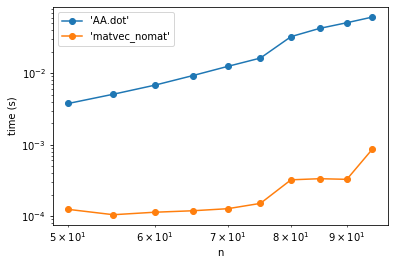

In [13]:
from time import perf_counter

def plot_time_comparison():
    '''
    function to plot the time
    comparison between matvec in 
    the "matrix free" version and
    in the regular version
    '''
    dims = range(50,100,5)
    
    time_matrix = []
    time_nomatrix = [] 
    
    for n in dims:
        
        x = np.random.rand(n**2)
        
        _, _, AA, _ = compute_two_dimensional_matrices(n)
        K, M, _, _ = compute_one_dimensional_matrices(n)
        
        start_mat = perf_counter()
        AA.dot(x)
        end_mat = perf_counter()
        
        delta_mat = end_mat - start_mat
        time_matrix.append(delta_mat)
        
        start_nomat = perf_counter()
        matvec_nomat(x, K, M)
        end_nomat = perf_counter()
        delta_nomat = end_nomat - start_nomat
        time_nomatrix.append(delta_nomat)
        
    plt.loglog(dims, time_matrix, '-o', label = "'AA.dot'")
    plt.loglog(dims, time_nomatrix, '-o', label = "'matvec_nomat'")
    plt.legend()
    plt.xlabel('n')
    plt.ylabel('time (s)')
    
plot_time_comparison()